<a href="https://colab.research.google.com/github/AliNokia/INTRODUCTION-TO-XR-2024/blob/main/internshipdatascrapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install asyncpraw pandas nest_asyncio aiohttp


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 2.9 MB/s eta 0:00:00


In [2]:
import asyncpraw
import pandas as pd
import asyncio
import nest_asyncio
from tqdm import tqdm
import aiohttp

# Apply nest_asyncio to allow nested event loops in Colab
nest_asyncio.apply()


In [3]:
REDDIT_CLIENT_ID = 'VF5u76TfDfmEIRgzgalbYw'
REDDIT_SECRET = 'wDg_OEysIIlOvqvCwoZvMXyobaYkiQ'
REDDIT_USER_AGENT = 'Kitchen-Cow-8358'

In [4]:
# Initialize Reddit instance
reddit = asyncpraw.Reddit(
    client_id=REDDIT_CLIENT_ID,
    client_secret=REDDIT_SECRET,
    user_agent=REDDIT_USER_AGENT,
    ratelimit_seconds=10
)

async def fetch_posts(subreddit_name, limit=1000):
    subreddit = await reddit.subreddit(subreddit_name)
    posts = []

    async for post in subreddit.hot(limit=limit):
        await post.load()
        posts.append({
            'subreddit': subreddit_name,
            'post_id': post.id,
            'title': post.title,
            'score': post.score,
            'num_comments': post.num_comments,
            'selftext': post.selftext,
            'created_utc': post.created_utc,
            'comments': await fetch_comments(post)
        })
        await asyncio.sleep(1)  # Slight delay to avoid rate limits

    return posts

async def fetch_comments(post):
    comments = []
    await post.comments.replace_more(limit=None)
    for comment in post.comments.list():
        comments.append({
            'comment_id': comment.id,
            'body': comment.body,
            'score': comment.score,
            'created_utc': comment.created_utc,
            'parent_id': comment.parent_id,
            'depth': comment.depth
        })
    return comments

async def fetch_all_data(subreddits, post_limit=1000):
    all_posts = []
    for subreddit in subreddits:
        print(f'Scraping {subreddit}...')
        posts = await fetch_posts(subreddit, limit=post_limit)
        all_posts.extend(posts)
    return all_posts


In [5]:
# Define the subreddits and start scraping
subreddits = ['gradschool', 'academia']
all_posts = asyncio.run(fetch_all_data(subreddits, post_limit=5000))

# Save to a DataFrame and export to CSV
df = pd.DataFrame(all_posts)
df.to_csv('reddit_posts_with_comments_and_replies.csv', index=False)
print('Scraping complete. Data saved to reddit_posts_with_comments_and_replies.csv.')


Scraping gradschool...
Scraping academia...
Scraping complete. Data saved to reddit_posts_with_comments_and_replies.csv.


In [7]:
# Load the data from the CSV to verify
df = pd.read_csv('reddit_posts_with_comments_and_replies.csv')
print(df.head())


    subreddit  post_id                                              title  \
0  gradschool  1f933ux    My gf broke up with me the day before I defend    
1  gradschool  1f8ioi4  My professor told me to stop flirting with her..?   
2  gradschool  1f95t5f  Advice on how to comply with anti-plagiarism c...   
3  gradschool  1f95o0p  How to deal with a professor who seems to not ...   
4  gradschool  1f8l3nn   Defense was not as bad as I imagined it would be   

   score  num_comments                                           selftext  \
0     45            20  I already posted this week about my defense. I...   
1    772           370  I am a 28 M grad student at a local university...   
2      2             2  I delivered my master thesis couple of weeks a...   
3      2             1  How to deal with a professor who seems to not ...   
4     37             4  Finally defended today (and passed)!\n\nStill ...   

    created_utc                                           comments  
0  1.

In [8]:
from google.colab import files

# Upload the file
uploaded = files.upload()

# Check the uploaded files
import pandas as pd

df = pd.read_csv('reddit_posts_with_comments_and_replies.csv')
print(df.head())


Saving reddit_posts_with_comments_and_replies (1).csv to reddit_posts_with_comments_and_replies (1).csv
    subreddit  post_id                                              title  \
0  gradschool  1f933ux    My gf broke up with me the day before I defend    
1  gradschool  1f8ioi4  My professor told me to stop flirting with her..?   
2  gradschool  1f95t5f  Advice on how to comply with anti-plagiarism c...   
3  gradschool  1f95o0p  How to deal with a professor who seems to not ...   
4  gradschool  1f8l3nn   Defense was not as bad as I imagined it would be   

   score  num_comments                                           selftext  \
0     45            20  I already posted this week about my defense. I...   
1    772           370  I am a 28 M grad student at a local university...   
2      2             2  I delivered my master thesis couple of weeks a...   
3      2             1  How to deal with a professor who seems to not ...   
4     37             4  Finally defended today (

In [10]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora

nltk.download('punkt')
nltk.download('stopwords')

# Function to preprocess text
def preprocess_text(text):
    if pd.isna(text):  # Check for NaN values
        return []
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())  # Tokenize and lowercasing
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove stopwords and non-alphabetic tokens
    return tokens

# Assuming df is your DataFrame
df['title_tokens'] = df['title'].apply(preprocess_text)
df['selftext_tokens'] = df['selftext'].apply(preprocess_text)

# Combine tokens from title and selftext
df['all_tokens'] = df['title_tokens'] + df['selftext_tokens']

# Optionally, check for any remaining NaN values
print(df[['title', 'selftext', 'title_tokens', 'selftext_tokens', 'all_tokens']].isna().sum())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


title               0
selftext           75
title_tokens        0
selftext_tokens     0
all_tokens          0
dtype: int64


In [11]:
# Prepare corpus for LDA
texts = df['all_tokens'].tolist()
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Run LDA model
lda_model = gensim.models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

# Print topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)


(0, '0.008*"university" + 0.006*"school" + 0.006*"ai" + 0.005*"teaching" + 0.005*"use" + 0.004*"paper" + 0.004*"students" + 0.004*"years" + 0.004*"etc" + 0.004*"data"')
(1, '0.009*"masters" + 0.008*"really" + 0.007*"work" + 0.007*"school" + 0.006*"research" + 0.006*"job" + 0.005*"degree" + 0.005*"would" + 0.005*"time" + 0.005*"get"')
(2, '0.016*"phd" + 0.011*"would" + 0.010*"work" + 0.010*"research" + 0.008*"like" + 0.007*"want" + 0.007*"know" + 0.007*"year" + 0.007*"get" + 0.006*"program"')
(3, '0.008*"school" + 0.008*"like" + 0.008*"time" + 0.008*"would" + 0.008*"program" + 0.007*"grad" + 0.007*"lab" + 0.007*"get" + 0.007*"know" + 0.007*"one"')
(4, '0.012*"phd" + 0.011*"would" + 0.010*"research" + 0.007*"like" + 0.007*"want" + 0.007*"get" + 0.007*"work" + 0.006*"years" + 0.006*"know" + 0.006*"also"')
(5, '0.009*"would" + 0.008*"like" + 0.008*"school" + 0.008*"work" + 0.007*"get" + 0.006*"year" + 0.006*"job" + 0.006*"also" + 0.006*"know" + 0.005*"one"')
(6, '0.018*"research" + 0.012*"

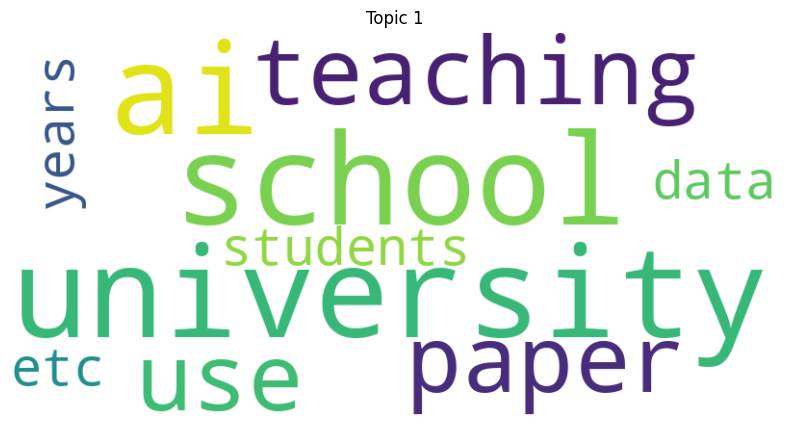

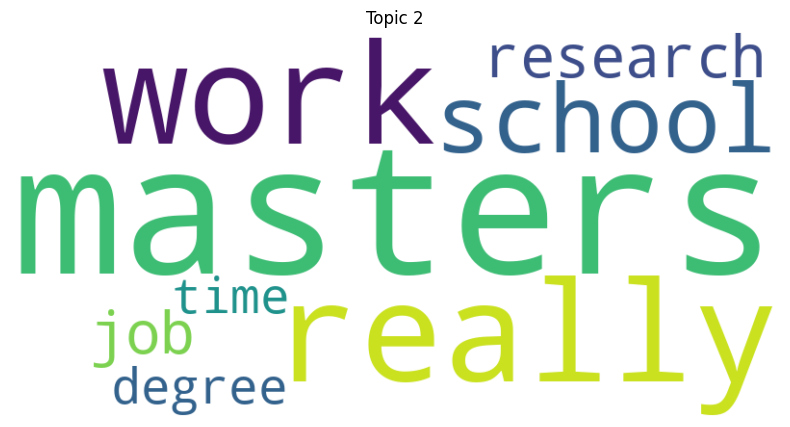

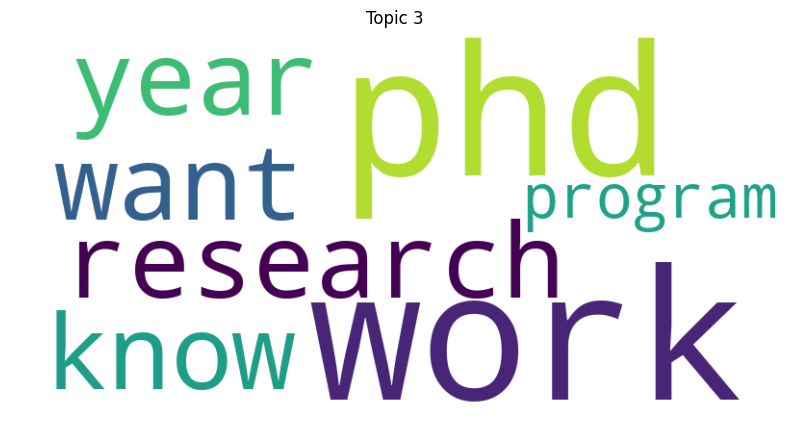

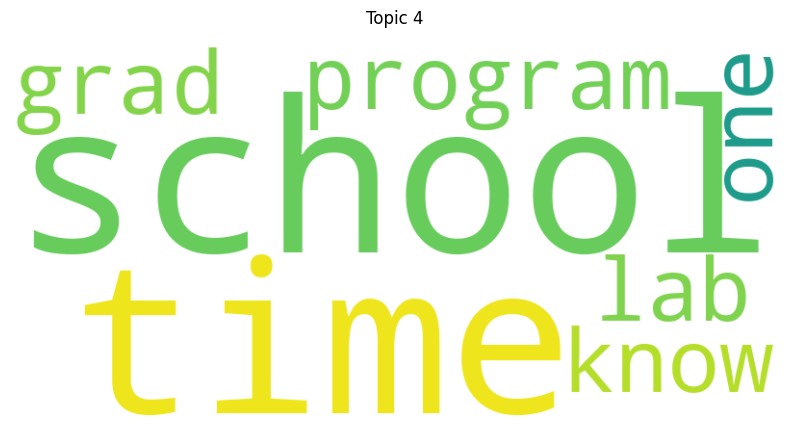

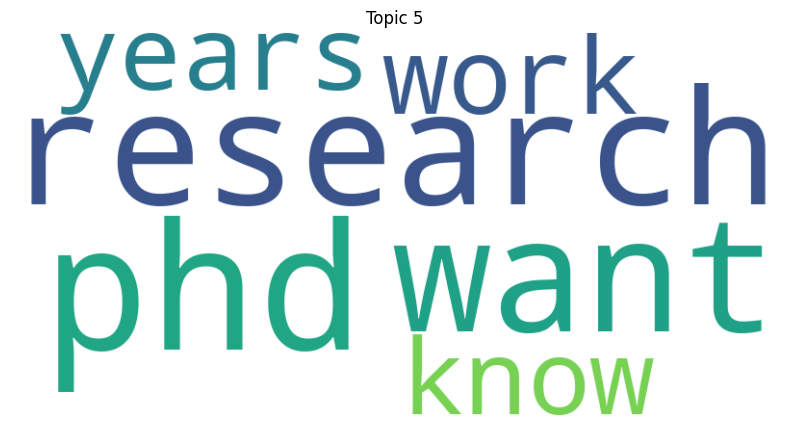

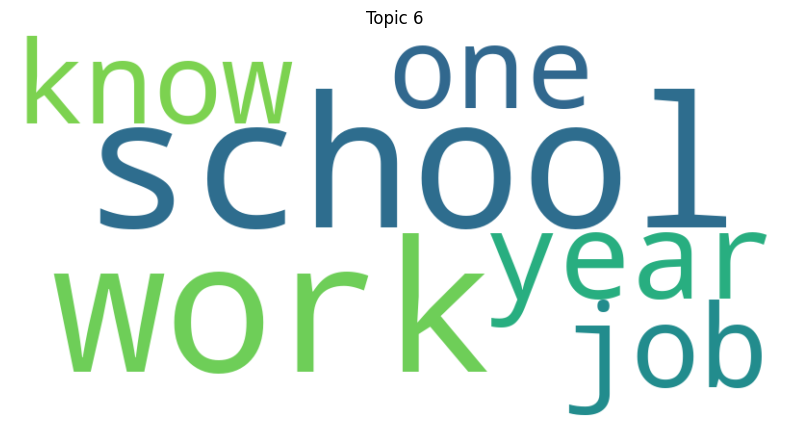

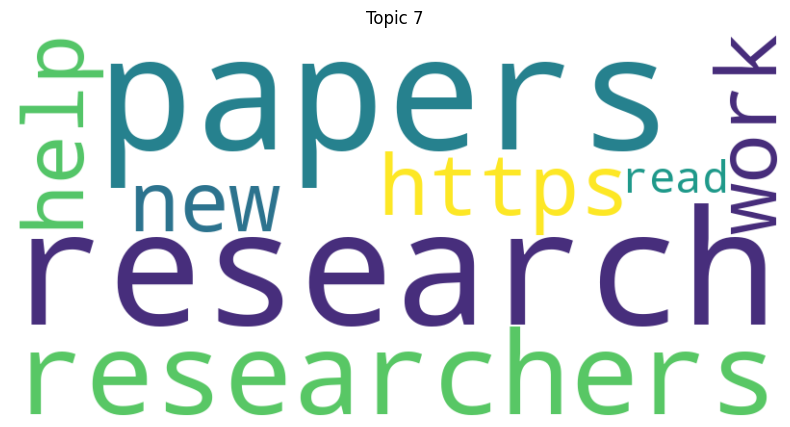

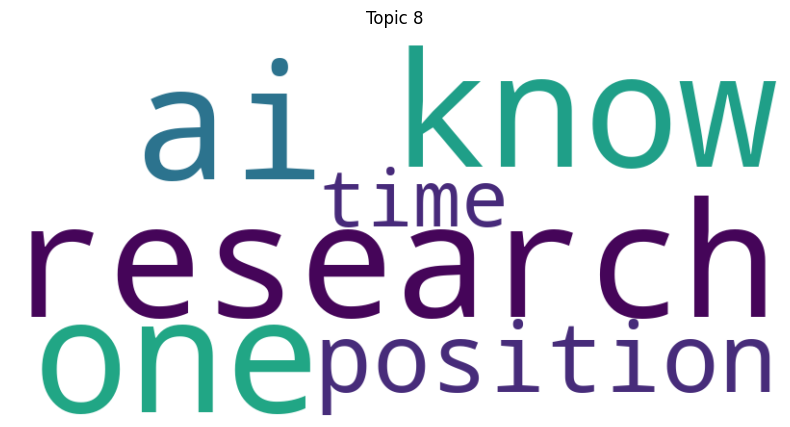

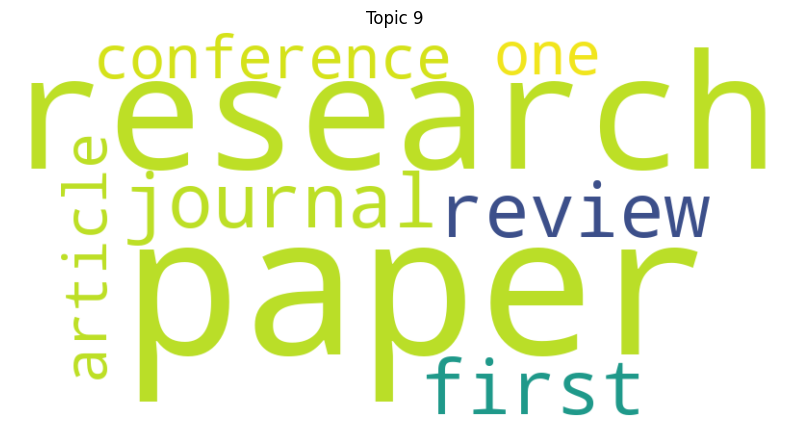

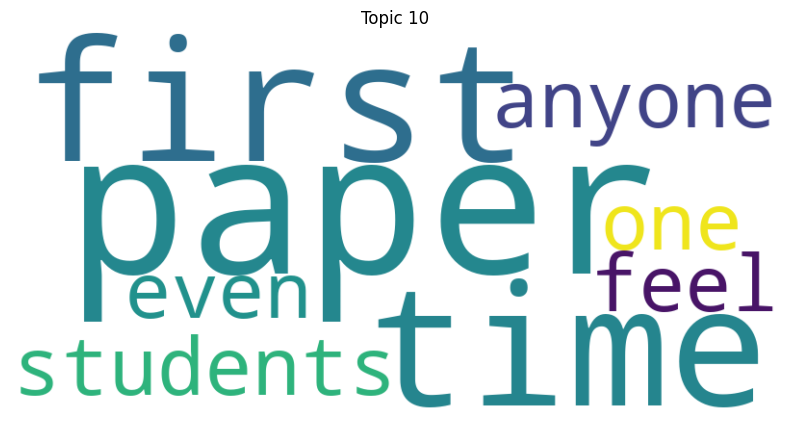

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def visualize_topics(lda_model, num_words=10):
    for i, topic in lda_model.show_topics(num_topics=-1, num_words=num_words, formatted=False):
        topic_words = ' '.join([word for word, _ in topic])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_words)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f'Topic {i+1}')
        plt.show()

# Visualize topics
visualize_topics(lda_model)



In [13]:
from gensim.models import CoherenceModel

def compute_coherence_score(lda_model, corpus, dictionary):
    coherence_model = CoherenceModel(model=lda_model, texts=df['all_tokens'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score

coherence_score = compute_coherence_score(lda_model, corpus, dictionary)
print(f"Coherence Score: {coherence_score:.4f}")


Coherence Score: 0.3547


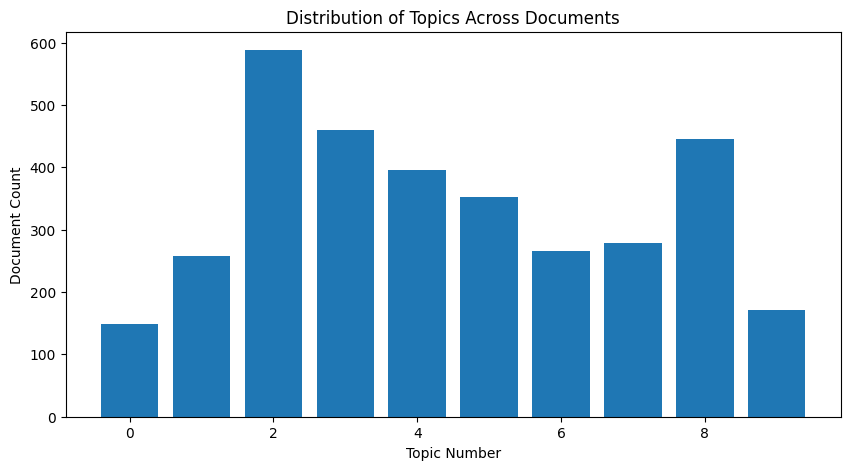

In [14]:
import numpy as np

def plot_topic_distribution(lda_model, corpus):
    topic_dist = [lda_model.get_document_topics(doc) for doc in corpus]
    topic_counts = np.zeros(lda_model.num_topics)

    for doc_topics in topic_dist:
        for topic, _ in doc_topics:
            topic_counts[topic] += 1

    plt.figure(figsize=(10, 5))
    plt.bar(range(lda_model.num_topics), topic_counts)
    plt.xlabel('Topic Number')
    plt.ylabel('Document Count')
    plt.title('Distribution of Topics Across Documents')
    plt.show()

plot_topic_distribution(lda_model, corpus)


In [15]:
from gensim.models import CoherenceModel

def compute_coherence_score(lda_model, corpus, dictionary):
    coherence_model = CoherenceModel(model=lda_model, texts=df['all_tokens'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score

coherence_score = compute_coherence_score(lda_model, corpus, dictionary)
print(f"Coherence Score: {coherence_score:.4f}")


Coherence Score: 0.3547


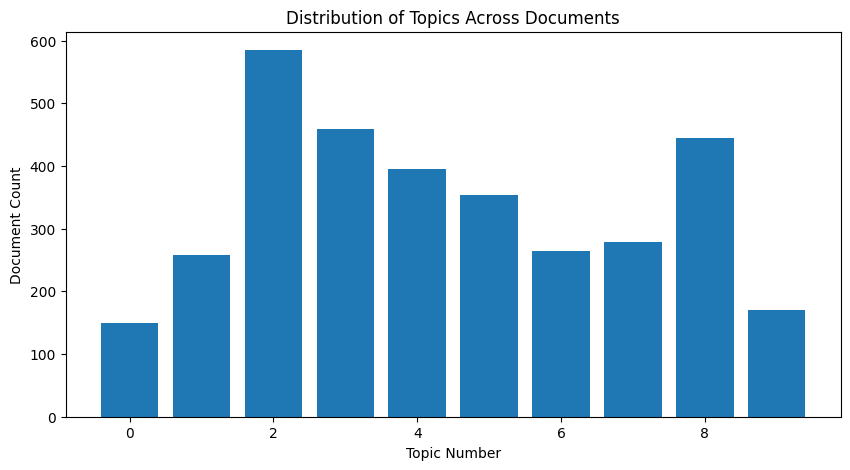

In [17]:
import numpy as np

def plot_topic_distribution(lda_model, corpus):
    topic_dist = [lda_model.get_document_topics(doc) for doc in corpus]
    topic_counts = np.zeros(lda_model.num_topics)

    for doc_topics in topic_dist:
        for topic, _ in doc_topics:
            topic_counts[topic] += 1

    plt.figure(figsize=(10, 5))
    plt.bar(range(lda_model.num_topics), topic_counts)
    plt.xlabel('Topic Number')
    plt.ylabel('Document Count')
    plt.title('Distribution of Topics Across Documents')
    plt.show()

plot_topic_distribution(lda_model, corpus)


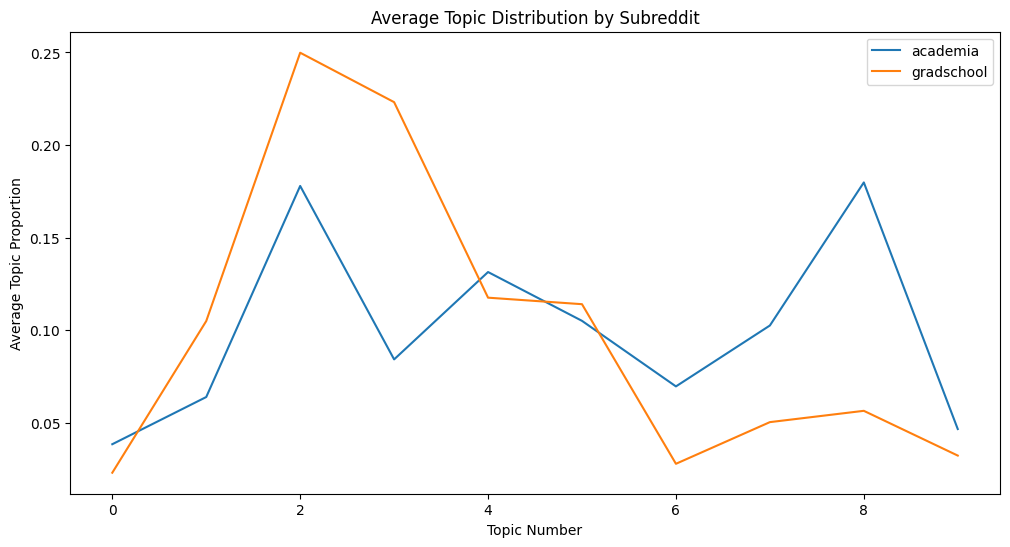

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_topic_distribution_by_subreddit(df, lda_model, dictionary):
    # Compute topic distribution for each document
    df['topic_distribution'] = df['all_tokens'].apply(lambda x: dict(lda_model.get_document_topics(dictionary.doc2bow(x), minimum_probability=0)))

    # Group by subreddit and calculate the average topic distribution
    def average_topic_distribution(topic_distributions):
        # Initialize an array for accumulating topic proportions
        topic_counts = np.zeros(lda_model.num_topics)
        num_docs = len(topic_distributions)

        for dist in topic_distributions:
            for topic, prob in dist.items():
                topic_counts[topic] += prob

        # Average the topic proportions
        return topic_counts / num_docs if num_docs > 0 else topic_counts

    subreddit_topics = df.groupby('subreddit')['topic_distribution'].apply(lambda x: average_topic_distribution(x))

    plt.figure(figsize=(12, 6))
    for subreddit, topics in subreddit_topics.items():
        plt.plot(range(lda_model.num_topics), topics, label=subreddit)

    plt.xlabel('Topic Number')
    plt.ylabel('Average Topic Proportion')
    plt.title('Average Topic Distribution by Subreddit')
    plt.legend()
    plt.show()

# Call the function
plot_topic_distribution_by_subreddit(df, lda_model, dictionary)

